# Reachability analysis of non-linear continuous and hybrid systems - Joe Khawand

The goal of this project is to implement a bounded horizon Taylor expansion based reachability analysis for non-linear continuous systems.
We've chosen to implement this method in python using **sympy** for the symbolic calculations, **numpy** for numerical applications, **pyinterval** for interval arithmetic, and finally **matplotlib** for plotting the results.

Our first implementation will be focused on functions **f** that only take two variables: **x(t)** and **t**. We will extend this implementation in the second part of this report to multivariate application.

## The code
We start first of all by importing the required libraries:

In [1]:
from sympy import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from interval import *

x,y,t= symbols('x y t')


We then implement the **boundingBox** detailed in the course slides, wich computes a valid step h and a bounding box B given a function f(x,t)

In [2]:
def BoundingBox(X,h,a,f,t):
    B = X+interval[0,h] *interval(f(X,t)[0])
    while (not ((X+interval[0,h]*interval(f(B,t)[0])) in B)):
        B = X+interval[0,h]*interval(f(B,t)[0])
        B = B+interval[-a,a]*B
        h=h/2.0
    return h, B

After that we implement the taylor expansion algorithm described in the course using the symbolic calculation library **sympy**. This implementation is divided in 3 steps:
1. First we calculate the first n-1 elements by using the differenciate method and adding the taylor coefficients on each step. 
2. Then we calculate the last taylor coefficient and replace the variable **x** by a variable **y** because in the model the last taylor coefficient takes the bounding box **B** as an argument and the other coefficients take **Xj**.
3. We finally transform the symbolic function we obtained to a **lambda python function** so that we can apply intervals and numerical values to it.

In [3]:
def taylor_expansion(f,tj,n): 
    #Taylor expansion for the equation x'=f(x,t)
    func=f
    #We start by writing our first two orders
    dif=x+f.subs(t,tj)*(t-tj)
    #Then we loop on all our orders-1
    for i in range(2,n):
        func = (func.diff(t,1) + func.diff(x,1)*f).simplify() #y(i+1)=(y(i))'
        dif+= ((((t-tj)**i)/factorial(i))*func.subs(t,tj)).simplify()
    #For the last order we replace the variable x by y because this last coefficient will take B as an input
    func = (func.diff(t,1) + func.diff(x,1)*f).simplify()
    dif+= (((t-tj)**n)/factorial(n))*(func.subs(t,tj).subs(x,y))
    #Lastly we return a lambdified function applicable to intervals
    return lambdify([x,t,y],dif.simplify())

Finally, we create a function that execute our algorithm and plots the desired graph:

In [4]:
def calculate_and_plot(X0,n,f,t_final,a):
    #Set the size of the figure
    
    default_figsize = mpl.rcParamsDefault['figure.figsize']
    mpl.rcParams['figure.figsize'] = [2.0*val for val in default_figsize]
    plt.figure(figsize=(12,8))
    
    #Initialize the start values
    Xj=X0
    t_curr=0
    h=0.2
    last_elem = (Xj[0].sup+Xj[0].inf)/2.0

    while(t_curr<=t_final):
        h=0.2
        #Calculate bounding Box
        h,B=BoundingBox(Xj,h,a,lambdify([x,t],f),t_curr) #f(z,t)
        
        #Calculate next step using h
        t_next=t_curr+h
        
        #Calculate the taylor expansion and apply it to the interval Xj to calculate Xj+1
        g = taylor_expansion(f,t_curr,n)
        Xj2= interval(g(Xj,t_next,B)[0])#tj+h
        
        #Plot a directive function in the middle of the interval
        ls_t = np.linspace(t_curr,t_next,20)
        g_ls_t = [g(last_elem,e,B)[0,0] for e in ls_t]
        plt.plot(ls_t,g_ls_t,color='r')
        
        #Plot the Boxes
        plt.plot([t_curr,t_curr,t_next,t_next,t_curr],[Xj[0].inf,Xj[0].sup,Xj2[0].sup,Xj2[0].inf,Xj[0].inf],color='b')
        plt.plot([t_curr,t_curr,t_next,t_next,t_curr],[B[0].inf,B[0].sup,B[0].sup,B[0].inf,B[0].inf],color='g')
        
        #Set up for next loop
        last_elem = g_ls_t[-1]
        t_curr=t_next
        Xj=Xj2
        
    plt.show()
    

## Examples

**Note that :**
- The blue polygones represent **unbloated** zonotopes. The vertical lines at each step represent Xj.
- The red function represents the taylor expansion of our calculated function applied on the middle of our interval.
- The green boxes represent the calculated bounding boxes at each step


 Taylor model applied to x'=sin(x) 



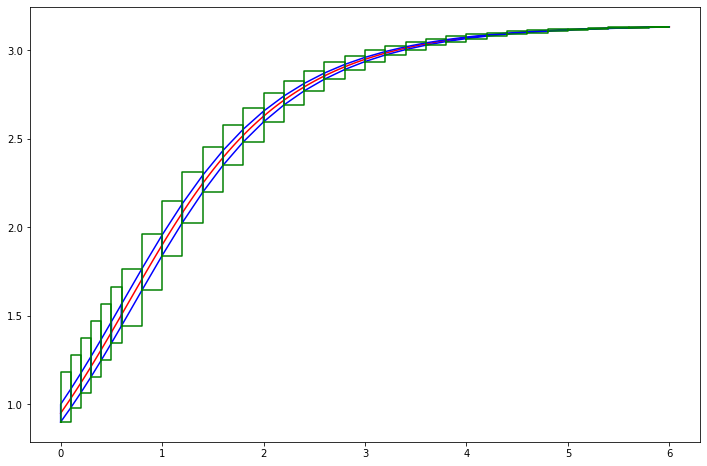

In [5]:
# x'=sin(x)
print("\n","Taylor model applied to x'=sin(x) \n")
calculate_and_plot(interval([0.9,1.]),5,sin(x),6,0)


 Taylor model applied to x'=-x+t 



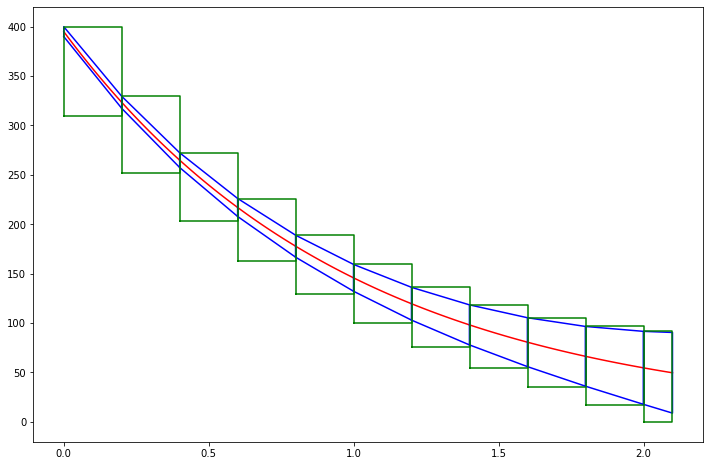

In [6]:
# x'=-x+t
print("\n","Taylor model applied to x'=-x+t \n")
calculate_and_plot(interval([390,400]),5,-x+t,2,0)

**We notice here that in comparaison to the last plot our bounding boxes start to get bigger. That is the warping effect that we talked about in the course. 
That effect is also coupled with sympys' inability to deal with very small values, leading to huge divergences in certain plots.**

**For example in this function if we increase the horizon, the values will start to diverge:**


 Taylor model applied to x'=-x+t 



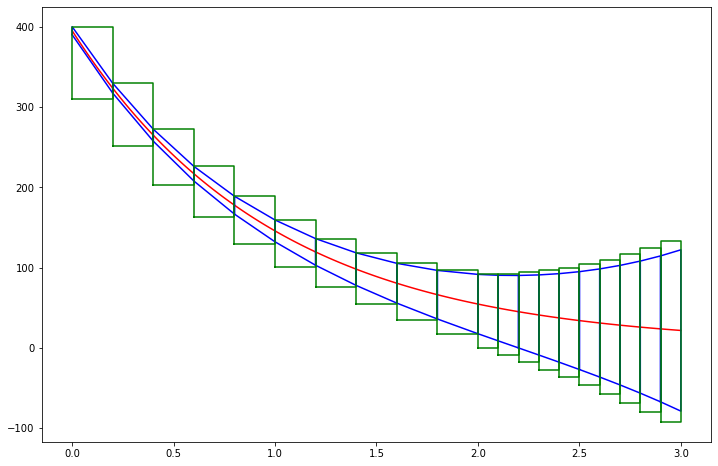

In [7]:
# x'=-x+t
print("\n","Taylor model applied to x'=-x+t \n")
calculate_and_plot(interval([390,400]),5,-x+t,3,0)


 Taylor model applied to x'=cos(x) 



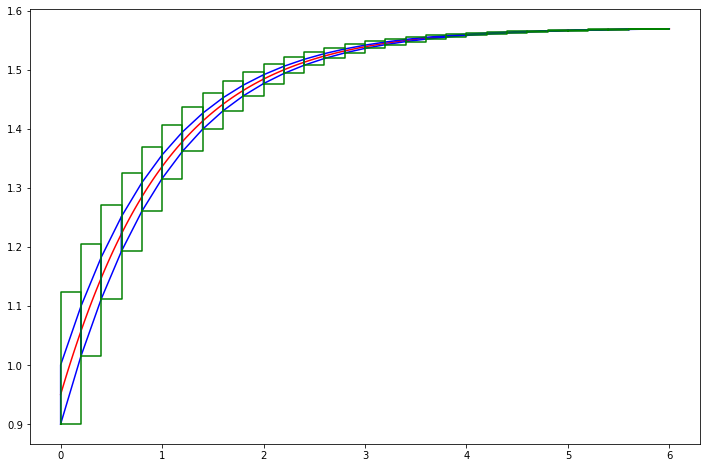

In [8]:
print("\n","Taylor model applied to x'=cos(x) \n")
calculate_and_plot(interval([0.9,1.]),5,cos(x),6,0)

# Application : SEIR

## Model Description
Compartmental models are a very general modelling technique. They are often applied to the mathematical modelling of infectious diseases.

The **SEIR** Model tries to predict things such as how a disease spreads, the total number infected, the duration of an epidemic, and estimate various epidemiological parameters such as the reproductive number. 

The dynamics of this model are described as follows:
$$
   \left\{ \begin{array}{lcl}
   \frac{dS}{dt} & = & \beta I S \\
   \frac{dE}{dt} & = & \beta I S - \alpha E \\
   \frac{dI}{dt} & = & -\gamma I + \alpha E \\
   \frac{dR}{dt} & = & \gamma I
   \end{array} \right.
$$
where $S$ is the stock of susceptible population, $E$ is the stock of exposed population,$I$ is the stock of infected, $R$ is the stock of removed population (either by death or recovery), with $S+E+I+R=N$.

## Implementation
To implement this model and calculate its reachability, we adapt the functions created in the first part of this document. The only difference is that the differentiation by x in the **taylor_expansion** function is now a differentiation by a vector **x=(S,E,I,R)**. 
But since the sympy library does not support vectors of arbitrary size n, we reimplemented the calculations by hand. 
This is not very elegant, but gets the job done.


In [9]:
# We start by defining our symbols

S,E,I,R= symbols('S E I R')
yS,yE,yI,yR= symbols('yS yE yI yR')

##############################################################################################
#Functions for S:

def taylor_expansionS(fS,fE,fI,fR,tj,n): 
    
    func=fS
    dif=S+func.subs(t,tj)*(t-tj)
    for i in range(2,n):
        func = (func.diff(t,1) + func.diff(S,1)*fS + func.diff(E,1)*fE + func.diff(I,1)*fI + func.diff(R,1)*fR).simplify() 
        dif+= ((((t-tj)**i)/factorial(i))*func.subs(t,tj)).simplify()
    func = (func.diff(t,1) + func.diff(S,1)*fS + func.diff(E,1)*fE + func.diff(I,1)*fI + func.diff(R,1)*fR).simplify()
    dif+= (((t-tj)**n)/factorial(n))*(func.subs(t,tj).subs(S,yS).subs(E,yE).subs(I,yI).subs(R,yR))
    return lambdify([S,E,I,R,t,yS,yE,yI,yR],dif.simplify())

def calculate_BoundingBoxS(XS,XE,XI,XR,h,a,f,t):
    B = XS+interval([0,h])*interval(f(XS,XE,XI,XR,t)[0])
    while (not ((XS+interval([0,h])*interval(f(B,XE,XI,XR,t)[0])) in B)):
        B = XS+interval([0,h])*interval(f(B,XE,XI,XR,t)[0])
        B = B+interval([-a,a])*B
        h=h/2.0
    return h, B

##############################################################################################
#Functions for E:

def taylor_expansionE(fS,fE,fI,fR,tj,n):
    
    func=fE
    dif=E+func.subs(t,tj)*(t-tj)
    for i in range(2,n):
        func = (func.diff(t,1) + func.diff(S,1)*fS + func.diff(E,1)*fE + func.diff(I,1)*fI + func.diff(R,1)*fR).simplify() 
        dif+= ((((t-tj)**i)/factorial(i))*func.subs(t,tj)).simplify()
    func = (func.diff(t,1) + func.diff(S,1)*fS + func.diff(E,1)*fE + func.diff(I,1)*fI + func.diff(R,1)*fR).simplify()
    dif+= (((t-tj)**n)/factorial(n))*(func.subs(t,tj).subs(S,yS).subs(E,yE).subs(I,yI).subs(R,yR))
    return lambdify([S,E,I,R,t,yS,yE,yI,yR],dif.simplify())

def calculate_BoundingBoxE(XS,XE,XI,XR,h,a,f,t):
    B = XE+interval([0,h])*interval(f(XS,XE,XI,XR,t)[0])
    while (not ((XE+interval([0,h])*interval(f(XS,B,XI,XR,t)[0])) in B)):
        B = XE+interval([0,h])*interval(f(XS,B,XI,XR,t)[0])
        B = B+interval([-a,a])*B
        h=h/2.0
    return h, B

##############################################################################################
#Functions for I:

def taylor_expansionI(fS,fE,fI,fR,tj,n): 
    
    func=fI
    dif=I+func.subs(t,tj)*(t-tj)
    for i in range(2,n):
        func = (func.diff(t,1) + func.diff(S,1)*fS + func.diff(E,1)*fE + func.diff(I,1)*fI + func.diff(R,1)*fR).simplify() 
        dif+= ((((t-tj)**i)/factorial(i))*func.subs(t,tj)).simplify()
    func = (func.diff(t,1) + func.diff(S,1)*fS + func.diff(E,1)*fE + func.diff(I,1)*fI + func.diff(R,1)*fR).simplify()
    dif+= (((t-tj)**n)/factorial(n))*(func.subs(t,tj).subs(S,yS).subs(E,yE).subs(I,yI).subs(R,yR))
    return lambdify([S,E,I,R,t,yS,yE,yI,yR],dif.simplify())

def calculate_BoundingBoxI(XS,XE,XI,XR,h,a,f,t):
    B = XI+interval([0,h])*interval(f(XS,XE,XI,XR,t)[0])
    while (not ((XI+interval([0,h])*interval(f(XS,XE,B,XR,t)[0])) in B)):
        B = XI+interval([0,h])*interval(f(XS,XE,B,XR,t)[0])
        B = B+interval([-a,a])*B
        h=h/2.0
    return h, B

##############################################################################################
#Functions for R:

def taylor_expansionR(fS,fE,fI,fR,tj,n): 
    
    func=fR
    dif=R+func.subs(t,tj)*(t-tj)
    for i in range(2,n):
        func = (func.diff(t,1) + func.diff(S,1)*fS + func.diff(E,1)*fE + func.diff(I,1)*fI + func.diff(R,1)*fR).simplify() 
        dif+= ((((t-tj)**i)/factorial(i))*func.subs(t,tj)).simplify()
    func = (func.diff(t,1) + func.diff(S,1)*fS + func.diff(E,1)*fE + func.diff(I,1)*fI + func.diff(R,1)*fR).simplify()
    dif+= (((t-tj)**n)/factorial(n))*(func.subs(t,tj).subs(S,yS).subs(E,yE).subs(I,yI).subs(R,yR))
    return lambdify([S,E,I,R,t,yS,yE,yI,yR],dif.simplify())

def calculate_BoundingBoxR(XS,XE,XI,XR,h,a,f,t):
    B = XR+interval([0,h])*interval(f(XS,XE,XI,XR,t)[0])
    while (not ((XR+interval([0,h])*interval(f(XS,XE,XI,B,t)[0])) in B)):
        B = XR+interval([0,h])*interval(f(XS,XE,XI,B,t)[0])
        B = B+interval([-a,a])*B
        h=h/2.0
    return h, B

##############################################################################################
##############################################################################################

def calculate_and_plot_SEIR(S0,E0,I0,R0,n,fS,fE,fI,fR,nb_steps,a):
    default_figsize = mpl.rcParamsDefault['figure.figsize']
    mpl.rcParams['figure.figsize'] = [2.0*val for val in default_figsize]
    plt.figure(figsize=(12,8))
    #init
    XSj, XEj, XIj, XRj = S0, E0, I0, R0
    t_curr=50
    last_elemS, last_elemE, last_elemI, last_elemR = (XSj[0].sup+XSj[0].inf)/2.0, (XEj[0].sup+XEj[0].inf)/2.0, (XIj[0].sup+XIj[0].inf)/2.0, (XRj[0].sup+XRj[0].inf)/2.0
    step = 0
    
    while(step<nb_steps):
        
        hS, hE, hI, hR =1, 1, 1, 1
        hS,BS=calculate_BoundingBoxS(XSj, XEj, XIj, XRj,hS,a,lambdify([S,E,I,R,t],fS),t_curr)
        hE,BE=calculate_BoundingBoxE(XSj, XEj, XIj, XRj,hE,a,lambdify([S,E,I,R,t],fE),t_curr)
        hI,BI=calculate_BoundingBoxI(XSj, XEj, XIj, XRj,hI,a,lambdify([S,E,I,R,t],fI),t_curr)
        hR,BR=calculate_BoundingBoxR(XSj, XEj, XIj, XRj,hR,a,lambdify([S,E,I,R,t],fR),t_curr)
        t_next=t_curr+min(min(hS,hE),min(hI,hR))
        gS = taylor_expansionS(fS,fE,fI,fR,t_curr,n)
        gE = taylor_expansionE(fS,fE,fI,fR,t_curr,n)
        gI = taylor_expansionI(fS,fE,fI,fR,t_curr,n)
        gR = taylor_expansionR(fS,fE,fI,fR,t_curr,n)
        XSj2= interval(gS(XSj,XEj,XIj,XRj,t_next,BS,BE,BI,BR)[0])
        XEj2= interval(gE(XSj,XEj,XIj,XRj,t_next,BS,BE,BI,BR)[0])
        XIj2= interval(gI(XSj,XEj,XIj,XRj,t_next,BS,BE,BI,BR)[0])
        XRj2= interval(gR(XSj,XEj,XIj,XRj,t_next,BS,BE,BI,BR)[0])
        
        #Plot the function in the middle of the starting interval
        ls_t = np.linspace(t_curr,t_next,20)
        g_ls_tS = [gS(last_elemS,XEj,XIj,XRj,e,BS,BE,BI,BR)[0,0] for e in ls_t]
        g_ls_tE = [gE(XSj,last_elemE,XIj,XRj,e,BS,BE,BI,BR)[0,0] for e in ls_t]
        g_ls_tI = [gI(XSj,XEj,last_elemI,XRj,e,BS,BE,BI,BR)[0,0] for e in ls_t]
        g_ls_tR = [gR(XSj,XEj,XIj,last_elemR,e,BS,BE,BI,BR)[0,0] for e in ls_t]
        plt.plot(ls_t,g_ls_tS,color='b')
        plt.plot(ls_t,g_ls_tE,color='g')
        plt.plot(ls_t,g_ls_tI,color='r')
        plt.plot(ls_t,g_ls_tR,color='k')
        
        #Plot the Boxes
        
        plt.plot([t_curr,t_curr,t_next,t_next,t_curr],[BS[0].inf,BS[0].sup,BS[0].sup,BS[0].inf,BS[0].inf],color='b')
        plt.plot([t_curr,t_curr,t_next,t_next,t_curr],[BE[0].inf,BE[0].sup,BE[0].sup,BE[0].inf,BE[0].inf],color='g')
        plt.plot([t_curr,t_curr,t_next,t_next,t_curr],[BI[0].inf,BI[0].sup,BI[0].sup,BI[0].inf,BI[0].inf],color='r')
        plt.plot([t_curr,t_curr,t_next,t_next,t_curr],[BR[0].inf,BR[0].sup,BR[0].sup,BR[0].inf,BR[0].inf],color='k')
        
        #Setup for next loop
        
        last_elemS, last_elemE, last_elemI, last_elemR = g_ls_tS[-1], g_ls_tE[-1], g_ls_tI[-1], g_ls_tR[-1]
        t_curr=t_next
        XSj,XEj,XIj,XRj = XSj2, XEj2, XIj2, XRj2
        step += 1
        
    plt.show()


## Reachability test
### Phase1

 The initial values used are:
 $$u₀ = [0.87,0.06,0.01,0.06]$$
 $$α = 0.2, β = 1.0, γ = 0.5 $$
 $$p = [α, β, γ]$$
 For a time span of 12 starting from 50.

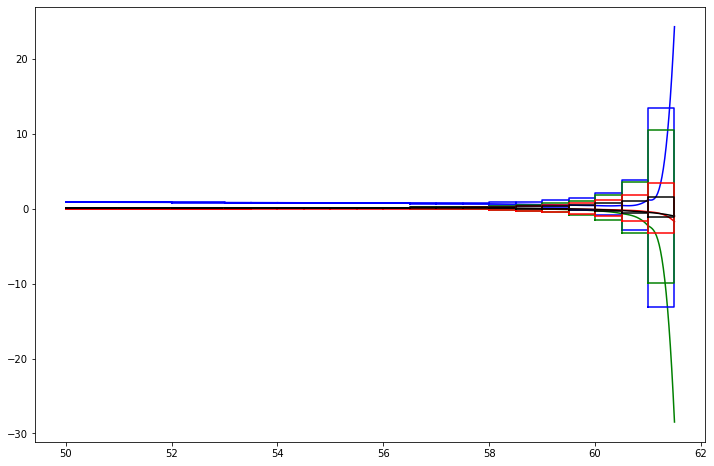

In [10]:
alpha = 0.2
beta = 1.0
gamma = 0.5
S0 = interval([0.87]) #interval([0.9999])
E0 = interval([0.06]) #interval([0.0001])
I0 = interval([0.01]) #interval([0])
R0 = interval([0.06]) #interval([0])
calculate_and_plot_SEIR(S0,E0,I0,R0,3,-beta*I*S,beta*I*S-alpha*E,-gamma*I+alpha*E,gamma*I,20,0)



**We notice here that due to the very small values taken by the functions at the start and the warping effect of the bounding boxes, we obtain a diverging solution.**

### Phase2
To remedy that we decided to remove the bounding box algorithm from the set and consider a fixed time step h. Our taylor expansion is then only evaluated in Xj removing the last element applied to B.

Below are the adapted functions:


In [11]:
t, S, E, I, R = symbols('t S E I R')

##############################################################################################

def taylor_expansionS2(fS,fE,fI,fR,tj,n): #f=Function('f')(S,E,I,R,t)
    # S' = f(S,E,I,R,t)
    func=fS
    dif=S+func.subs(t,tj)*(t-tj)
    for i in range(2,n+1):
        func = (func.diff(t,1) + func.diff(S,1)*fS + func.diff(E,1)*fE + func.diff(I,1)*fI + func.diff(R,1)*fR).simplify() 
        dif+= ((((t-tj)**i)/factorial(i))*func.subs(t,tj)).simplify()
    return lambdify([S,E,I,R,t],dif.simplify())

##############################################################################################

def taylor_expansionE2(fS,fE,fI,fR,tj,n): #f=Function('f')(S,E,I,R,t)
    # E' = f(S,E,I,R,t)
    func=fE
    dif=E+func.subs(t,tj)*(t-tj)
    for i in range(2,n+1):
        func = (func.diff(t,1) + func.diff(S,1)*fS + func.diff(E,1)*fE + func.diff(I,1)*fI + func.diff(R,1)*fR).simplify() 
        dif+= ((((t-tj)**i)/factorial(i))*func.subs(t,tj)).simplify()
    return lambdify([S,E,I,R,t],dif.simplify())

##############################################################################################

def taylor_expansionI2(fS,fE,fI,fR,tj,n): #f=Function('f')(S,E,I,R,t)
    # I' = f(S,E,I,R,t)
    func=fI
    dif=I+func.subs(t,tj)*(t-tj)
    for i in range(2,n+1):
        func = (func.diff(t,1) + func.diff(S,1)*fS + func.diff(E,1)*fE + func.diff(I,1)*fI + func.diff(R,1)*fR).simplify() 
        dif+= ((((t-tj)**i)/factorial(i))*func.subs(t,tj)).simplify()
    return lambdify([S,E,I,R,t],dif.simplify())

##############################################################################################

def taylor_expansionR2(fS,fE,fI,fR,tj,n): #f=Function('f')(S,E,I,R,t)
    # R' = f(S,E,I,R,t)
    func=fR
    dif=R+func.subs(t,tj)*(t-tj)
    for i in range(2,n+1):
        func = (func.diff(t,1) + func.diff(S,1)*fS + func.diff(E,1)*fE + func.diff(I,1)*fI + func.diff(R,1)*fR).simplify() 
        dif+= ((((t-tj)**i)/factorial(i))*func.subs(t,tj)).simplify()
    return lambdify([S,E,I,R,t],dif.simplify())

##############################################################################################
##############################################################################################

def calculate_and_plot_SEIR_2(S0,E0,I0,R0,n,fS,fE,fI,fR,nb_steps,a):
    default_figsize = mpl.rcParamsDefault['figure.figsize']
    mpl.rcParams['figure.figsize'] = [2.0*val for val in default_figsize]
    plt.figure(figsize=(12,8))
    
    #Initialization
    XSj, XEj, XIj, XRj = S0, E0, I0, R0
    t_curr=50
    last_elemS, last_elemE, last_elemI, last_elemR = (XSj[0].sup+XSj[0].inf)/2.0, (XEj[0].sup+XEj[0].inf)/2.0, (XIj[0].sup+XIj[0].inf)/2.0, (XRj[0].sup+XRj[0].inf)/2.0
    step = 0
    
    while(step<nb_steps):
        t_next=t_curr+1
        gS = taylor_expansionS2(fS,fE,fI,fR,t_curr,n)
        gE = taylor_expansionE2(fS,fE,fI,fR,t_curr,n)
        gI = taylor_expansionI2(fS,fE,fI,fR,t_curr,n)
        gR = taylor_expansionR2(fS,fE,fI,fR,t_curr,n)
        XSj2= interval(gS(XSj,XEj,XIj,XRj,t_next)[0])
        XEj2= interval(gE(XSj,XEj,XIj,XRj,t_next)[0])
        XIj2= interval(gI(XSj,XEj,XIj,XRj,t_next)[0])
        XRj2= interval(gR(XSj,XEj,XIj,XRj,t_next)[0])
        
        ls_t = np.linspace(t_curr,t_next,20)
        g_ls_tS = [gS(last_elemS,XEj,XIj,XRj,e)[0,0] for e in ls_t]
        g_ls_tE = [gE(XSj,last_elemE,XIj,XRj,e)[0,0] for e in ls_t]
        g_ls_tI = [gI(XSj,XEj,last_elemI,XRj,e)[0,0] for e in ls_t]
        g_ls_tR = [gR(XSj,XEj,XIj,last_elemR,e)[0,0] for e in ls_t]
        plt.plot(ls_t,g_ls_tS,color='b')
        plt.plot(ls_t,g_ls_tE,color='g')
        plt.plot(ls_t,g_ls_tI,color='r')
        plt.plot(ls_t,g_ls_tR,color='k')
        
        last_elemS, last_elemE, last_elemI, last_elemR = g_ls_tS[-1], g_ls_tE[-1], g_ls_tI[-1], g_ls_tR[-1]
        t_curr=t_next
        XSj,XEj,XIj,XRj = XSj2, XEj2, XIj2, XRj2
        step += 1
    
    plt.legend(["S","E","I","R"])
    plt.show()

We finally test using the same initial values:
$$u₀ = [0.87,0.06,0.01,0.06]$$
$$α = 0.2, β = 1.0, γ = 0.5 $$
$$p = [α, β, γ]$$
For a time span of 50 starting from 50.

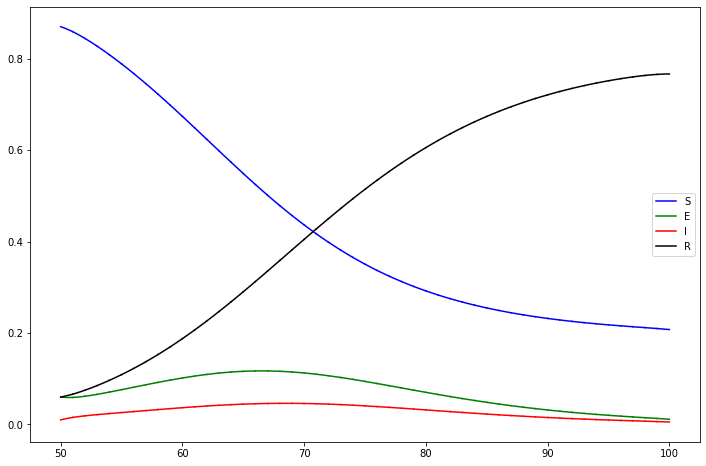

In [12]:
#Define the initial values
alpha = 0.2
beta = 1.0
gamma = 0.5
S0 = interval([0.87]) 
E0 = interval([0.06]) 
I0 = interval([0.01]) 
R0 = interval([0.06]) 
#Calculate and plot
calculate_and_plot_SEIR_2(S0,E0,I0,R0,3,-beta*I*S,beta*I*S-alpha*E,-gamma*I+alpha*E,gamma*I,50,0)

This corresponds perfectly to the model shown in [julia](https://juliareach.github.io/ReachabilityAnalysis.jl/dev/generated_examples/SEIR/) without the use of intervals.

**The final step of this implementation would be to use zonotopes on non-linear equations to avoid a divergence and thus plot our reachbility model with intervals.**